In [ ]:
import os
os.environ['SEQ_GRAPH_RETRO'] = 'E:\Learning_materials\Yanyi_xia\CSAI\GraphRetro'
from rdkit import Chem
from rdkit.Chem import  Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults

from typing import List, Dict, Tuple, Set
from collections import namedtuple, deque
ReactionInfo = namedtuple("ReactionInfo", ['rxn_smi', 'core', 'core_edits', 'lg_edits', 'attach_atoms', 'rxn_class'])

from seq_graph_retro.utils.chem import apply_edits_to_mol, get_mol, get_sub_mol
from seq_graph_retro.molgraph.mol_features import BOND_FLOAT_TO_TYPE
from seq_graph_retro.molgraph import MultiElement
from seq_graph_retro.utils.parse import get_reaction_info, extract_leaving_groups,get_reaction_core,get_bond_info
from seq_graph_retro.utils.edit_mol import canonicalize

from data_process.canonicalize_prod import remove_amap_not_in_product,remap_rxn_smi


In [14]:
def canonicalize_prod(p):
    pcanon = canonicalize(p)  # 清除氢原子和其原子映射
    pmol = Chem.MolFromSmiles(pcanon)
    [atom.SetAtomMapNum(atom.GetIdx()+1) for atom in pmol.GetAtoms()]  # 设置原子映射编号
    p = Chem.MolToSmiles(pmol)
    return p
def edits_split(n1,n2=0,n3=-1,n4=0,prod_mol=None):
    num1 = n1  # 5  6
    num2 = n2
    num3 = 1
    num4 = 0

    num5 = n3  # 8 9
    num6 = n4
    num7 = 1
    num8 = 0

    core_edits = [f'{num1}:{num2}:{num3}:{num4}']    #  a1:a2:b1:b2  --->   （产物原子编号）-起始：终止：原来的键类型：后来的键类型
    core_edits_1 = [f'{num5}:{num6}:{num7}:{num8}']

    fragments = apply_edits_to_mol(prod_mol, core_edits)  # 拆分--产物的分子表示+中心编辑
    fragments = Chem.MolToSmiles(fragments)
    fragment_list = []
    fragment_list = fragments.split('.')
    print('fragment_list',fragment_list)

    # 双键操作
    for fra in fragment_list:
        fra = Chem.MolFromSmiles(fra)
        franum_list = []
        print('ok')
        for atom in fra.GetAtoms():
            atomnum = atom.GetAtomMapNum()
            franum_list.append(atomnum)
        if num5 in franum_list :  # 判断是在哪个子图里面
            # fragment_list = fragment_list.remove(Chem.MolToSmiles(fra))

            # 删除 符合的第一次拆分的子图
            str1_mol = Chem.MolToSmiles(fra)
            str1 = str(str1_mol)
            fragment_list.remove(str1)

            fragments_1 = apply_edits_to_mol(fra, core_edits_1)  # 拆分--产物的分子表示+中心编辑
            fragments_1 = Chem.MolToSmiles(fragments_1).split('.')
            print('fragments_1:',fragments_1)
            fragment_list = fragment_list + fragments_1
            print('fragment_list_aaa:',fragment_list)

    molecules = [Chem.MolFromSmiles(fragment) for fragment in fragment_list]
    img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(400, 400))
    display(img)

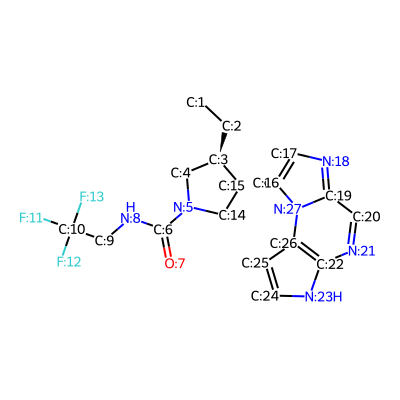

fragment_list ['[C:1][C:2][C@:3]1[C:4][N:5][C:14][C@:15]1[c:16]1[c:17][n:18][c:19]2[c:20][n:21][c:22]3[nH:23][c:24][c:25][c:26]3[n:27]12', '[C:6](=[O:7])[N:8][C:9][C:10]([F:11])([F:12])[F:13]']
ok
fragments_1: ['[C:1][C:2][C:3]1[C:4][N:5][C:14][C:15]1', '[c:16]1[c:17][n:18][c:19]2[c:20][n:21][c:22]3[nH:23][c:24][c:25][c:26]3[n:27]12']
fragment_list_aaa: ['[C:6](=[O:7])[N:8][C:9][C:10]([F:11])([F:12])[F:13]', '[C:1][C:2][C:3]1[C:4][N:5][C:14][C:15]1', '[c:16]1[c:17][n:18][c:19]2[c:20][n:21][c:22]3[nH:23][c:24][c:25][c:26]3[n:27]12']


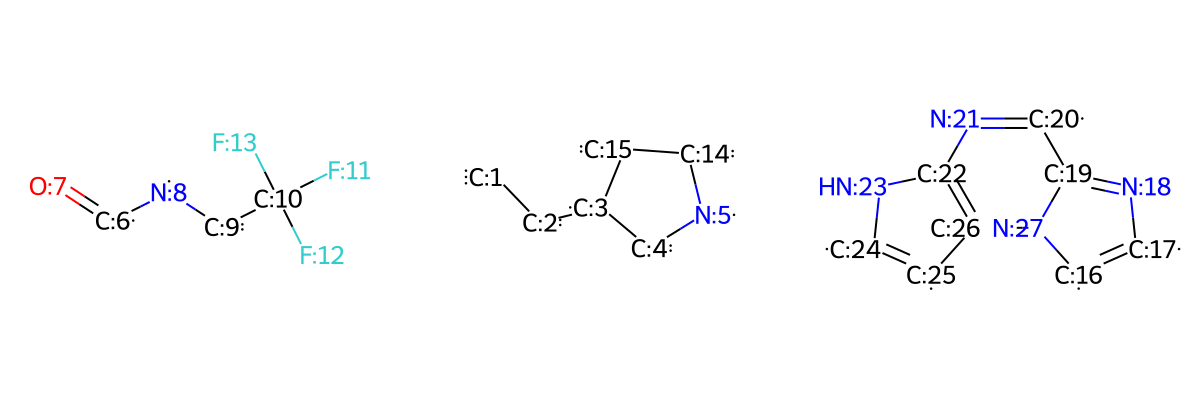

In [15]:
rxn_smi = ('CC[C@H](CN(C(NCC(F)(F)F)=O)C1)[C@H]1C2=CN=C3C=NC4=C(C=CN4)N32')
prod_mol = canonicalize_prod(rxn_smi)
prod_mol = get_mol(prod_mol)

img = Draw.MolToImage(prod_mol, size=(400, 400))
display(img)


edits_split(5,6,15,16,prod_mol)